In [1]:
import pandas as pd
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# LightAutoML
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

In [2]:
data = pd.read_csv('/Users/awesome/Downloads/предсказание_спроса/train.csv', sep=';')
data = data.drop_duplicates()

In [3]:
def get_grouped_data(data):
    gr_period = data.groupby('period')['label'].mean().reset_index()
    gr_period.columns = ['period', 'label_by_period']
    new_data = pd.merge(data, gr_period, on='period')
    
    gr_per_subtype = data.groupby(['period','subject_type'])['label'].mean().reset_index()
    gr_per_subtype.columns = ['period','subject_type', 'label_by_per_subtype']
    new_data = pd.merge(new_data, gr_per_subtype, on=['period','subject_type'])
    
    gr_per_subtype_subname = data.groupby(['period','subject_type', 'subject_name'])['label'].mean().reset_index()
    gr_per_subtype_subname.columns = ['period', 'subject_type', 'subject_name', 'label_by_per_subtype_subname']
    new_data = pd.merge(new_data, gr_per_subtype_subname, on=['period','subject_type', 'subject_name'])

    gr_per_subtype_subname_city = data.groupby(['period','subject_type', 'subject_name', 'city_name'])['label'].mean().reset_index()
    gr_per_subtype_subname_city.columns = ['period', 'subject_type', 'subject_name', 'city_name', 'label_by_per_subtype_subname_city']
    new_data = pd.merge(new_data, gr_per_subtype_subname_city, on=['period','subject_type', 'subject_name', 'city_name'])
    
    sum_count = new_data.groupby('subject_name').agg(
        SumLabel=('label', 'sum'),
        CountLabel=('label', 'count')).reset_index()
    
    sum_count['percent_label'] = sum_count['SumLabel']/sum_count['CountLabel']
    new_data = pd.merge(new_data, sum_count, on=['subject_name'])

    return new_data

In [4]:
def select_columns(data):
    data = data[['label', 'label_by_per_subtype_subname_city','f12',
             'f3', 'f10', 'f11', 'f1', 'f15', 'hex_lat',
             'f2', 'hex_lon', 'label_by_per_subtype_subname',
             'f4', 'f6', 'f9', 'f8', 'f19', 'f25', 'f28',
             'label_by_per_subtype','f27', 'SumLabel',
             'CountLabel']]
    return data

In [5]:
data = get_grouped_data(data)

In [6]:
data.period = pd.to_datetime(data.period)

data['year'] = data.period.dt.year
data['month'] = data.period.dt.month
data['quarter_of_year'] = data.period.dt.quarter

In [7]:
data = select_columns(data)

In [8]:
data = data.fillna(data.median())

In [9]:
data.head()

,label,label_by_per_subtype_subname_city,f12,f3,f10,f11,f1,f15,hex_lat,f2,...,f6,f9,f8,f19,f25,f28,label_by_per_subtype,f27,SumLabel,CountLabel
0,1,0.03149,0.14816,0.00195,0.12653,0.33941,0.00101,0.00428,55.729458,0.00103,...,0.41452,0.00000,0.00000,0.26303,0.63074,0.03646,0.031534,0.00533,711,22551
1,1,0.03149,0.14645,0.00053,0.12478,0.31457,0.00000,0.00421,55.975851,0.00027,...,0.41452,0.00007,0.00007,0.17051,0.63074,0.03646,0.031534,0.00533,711,22551
2,1,0.03149,0.14791,0.00439,0.12628,0.32194,0.00339,0.00241,55.622721,0.00313,...,0.41452,0.00000,0.00000,0.24390,0.57895,0.00000,0.031534,0.02105,711,22551
3,1,0.03149,0.14969,0.00055,0.12810,0.31457,0.00048,0.00158,55.941586,0.00054,...,0.41452,0.00000,0.00000,0.20936,0.63074,0.03646,0.031534,0.00533,711,22551
4,1,0.03149,0.14841,0.00219,0.12626,0.31812,0.00164,0.00040,55.797494,0.00179,...,0.41452,0.00000,0.00000,0.22785,0.64444,0.01111,0.031534,0.04444,711,22551


In [10]:
N_THREADS = 16
N_FOLDS = 10
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 300
TARGET_NAME = 'label'

In [11]:
df_test = pd.read_csv('/Users/awesome/Downloads/предсказание_спроса/test.csv', sep=';')
df_test = df_test.drop_duplicates()
df_test = get_grouped_data(df_test)

df_test.period = pd.to_datetime(df_test.period)

df_test['year'] = df_test.period.dt.year
df_test['month'] = df_test.period.dt.month
df_test['quarter_of_year'] = df_test.period.dt.quarter

df_test = select_columns(df_test)
df_test = df_test.fillna(df_test.median())

In [12]:
df_test

,label,label_by_per_subtype_subname_city,f12,f3,f10,f11,f1,f15,hex_lat,f2,...,f6,f9,f8,f19,f25,f28,label_by_per_subtype,f27,SumLabel,CountLabel
0,1,0.082184,0.14823,0.00265,0.12608,0.32340,0.00292,0.00572,55.656639,0.00211,...,0.41867,0.00000,0.00000,0.25940,0.61603,0.03024,0.081958,0.01562,293,3575
1,1,0.082184,0.14740,0.00351,0.12576,0.32196,0.00265,0.00311,55.879910,0.00355,...,0.01098,0.00000,0.00000,0.26500,0.61603,0.03024,0.081958,0.01562,293,3575
2,1,0.082184,0.14865,0.00078,0.12601,0.31919,0.00046,0.00426,55.855726,0.00059,...,0.01727,0.00000,0.00000,0.30561,0.61603,0.03024,0.081958,0.01562,293,3575
3,1,0.082184,0.14791,0.00275,0.12628,0.31917,0.00304,0.00158,55.496542,0.00243,...,0.02330,0.00000,0.00000,0.36874,0.62252,0.00000,0.081958,0.00993,293,3575
4,1,0.082184,0.14839,0.00233,0.12677,0.31457,0.00183,0.00435,55.613025,0.00163,...,0.01028,0.00000,0.00000,0.19506,0.61603,0.03024,0.081958,0.01562,293,3575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6495,1,1.000000,0.15095,0.00113,0.12876,0.31807,0.00066,0.00192,62.065655,0.00084,...,0.01890,0.00000,0.00000,0.72727,0.72832,0.10405,1.000000,0.01156,7,7
6496,1,1.000000,0.16001,0.00021,0.13789,0.32090,0.00020,0.00055,63.727022,0.00017,...,0.42345,0.00000,0.00000,0.68304,0.86274,0.07843,1.000000,0.01307,7,7
6497,1,1.000000,0.15439,0.00124,0.13213,0.32070,0.00117,0.00009,65.942069,0.00141,...,0.12173,0.00000,0.00000,0.84345,0.61183,0.05176,1.000000,0.00370,7,7
6498,1,1.000000,0.15574,0.00615,0.13319,0.31457,0.00567,0.00055,63.057317,0.00539,...,0.42345,0.00000,0.00000,0.31818,0.61603,0.03024,1.000000,0.01562,7,7


In [13]:
tr_data = data.copy()
te_data = df_test.copy()

In [14]:
roles = {
    'target': TARGET_NAME
}

In [15]:
task = Task('binary')

In [16]:
RD = ReportDeco(output_path = 'tabularAutoML_model_report')

automl_rd = RD(
    TabularAutoML(
        task = task,
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
    )
)

In [17]:
%%time
oof_pred = automl_rd.fit_predict(tr_data, roles = roles, verbose = 1)

[12:18:43] Stdout logging level is INFO.
[12:18:43] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[12:18:43] Task: binary

[12:18:43] Start automl preset with listed constraints:
[12:18:43] - time: 300.00 seconds
[12:18:43] - CPU: 16 cores
[12:18:43] - memory: 16 GB

[12:18:43] Train data shape: (293942, 23)

[12:18:46] Layer 1 train process start. Time left 297.46 secs
[12:18:59] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[12:19:06] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8189874618319404
[12:19:06] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[12:19:06] Time left 276.74 secs

[12:19:30] Selector_LightGBM fitting and predicting completed
[12:19:45] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[12:20:54] Time limit exceeded after calculating fold 0

[12:20:54] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8882508191985181
[12:20:54] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting compl

In [18]:
!ls tabularAutoML_model_report

feature_importance.png                test_preds_distribution_by_bins_1.png
lama_interactive_report.html          test_preds_distribution_by_bins_4.png
test_distribution_of_logits_1.png     test_preds_distribution_by_bins_5.png
test_distribution_of_logits_4.png     test_roc_curve_1.png
test_distribution_of_logits_5.png     test_roc_curve_4.png
test_pie_f1_metric_1.png              test_roc_curve_5.png
test_pie_f1_metric_2.png              valid_distribution_of_logits.png
test_pie_f1_metric_4.png              valid_pie_f1_metric.png
test_pie_f1_metric_5.png              valid_pr_curve.png
test_pr_curve_1.png                   valid_preds_distribution_by_bins.png
test_pr_curve_4.png                   valid_roc_curve.png
test_pr_curve_5.png


In [19]:
te_pred = automl_rd.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[0.24086756],
       [0.31536928],
       [0.0833586 ],
       ...,
       [0.55556595],
       [0.56295973],
       [0.5467741 ]], dtype=float32)
Shape = (6500, 1)


In [20]:
print(classification_report(te_data[TARGET_NAME].values, te_pred.data[:, 0].round()))

              precision    recall  f1-score   support

           0       0.68      1.00      0.81      3282
           1       1.00      0.53      0.69      3218

    accuracy                           0.77      6500
   macro avg       0.84      0.77      0.75      6500
weighted avg       0.84      0.77      0.75      6500



In [21]:
cm = confusion_matrix(te_data[TARGET_NAME].values, te_pred.data[:, 0].round())

print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[3278    4]
 [1508 1710]]

True Positives(TP) =  3278

True Negatives(TN) =  1710

False Positives(FP) =  4

False Negatives(FN) =  1508


<AxesSubplot:xlabel='Feature'>

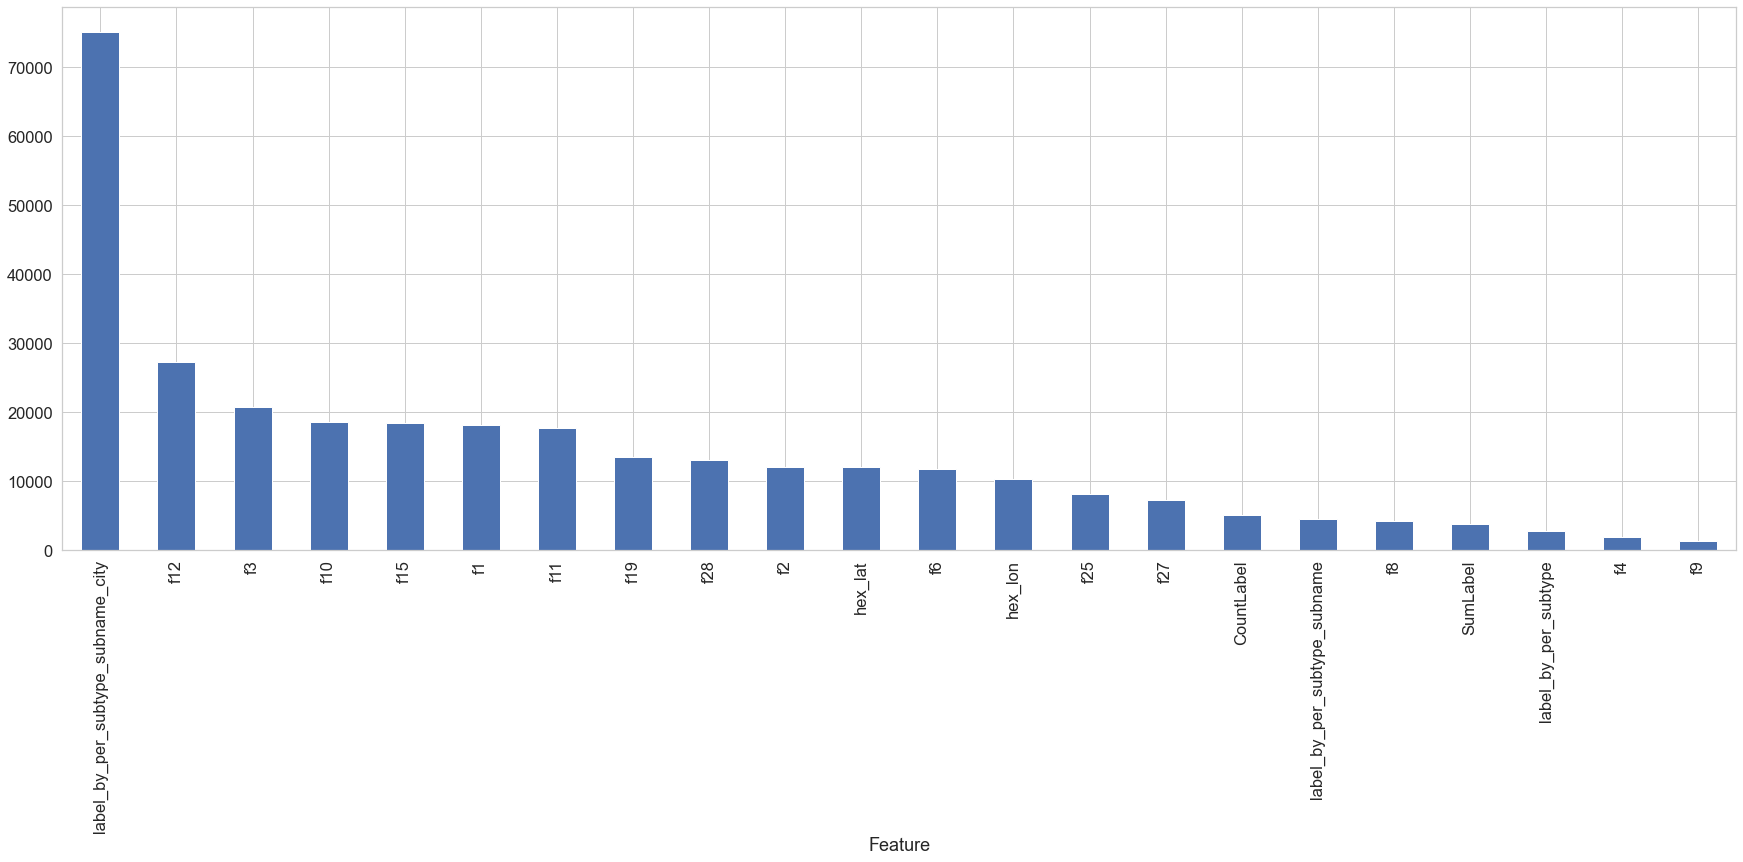

In [22]:
# feature importances 
fast_fi = automl_rd.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [23]:
# Accurate feature importances calculation (Permutation importances)
accurate_fi = automl_rd.model.get_feature_scores('accurate', te_data, silent = False)

<AxesSubplot:xlabel='Feature'>

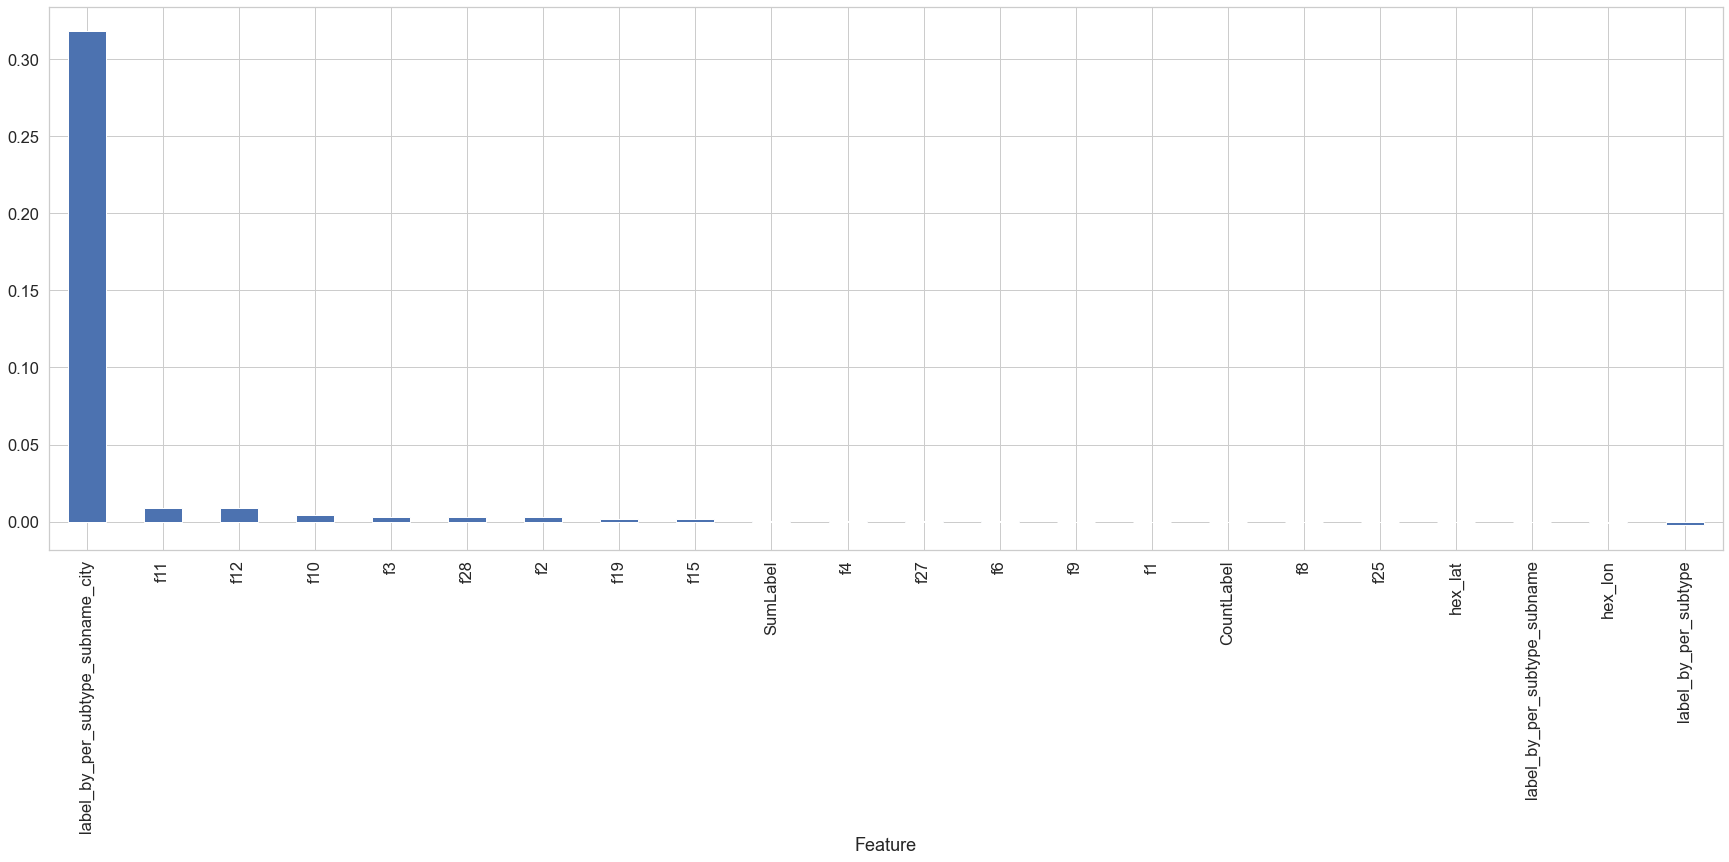

In [24]:
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [25]:
# top_20_features = accurate_fi["Feature"].head(20).values.tolist()
# top_20_features